# MSBD 5001 in-class project

**Description**
The dataset provides the average traffic speed per hour for a major road in Hong Kong from 2017 to 2018. Part of the dataset is provided as the training data, and your task is to predict the rest. 80% of the dataset is provided as the training data and 20% as the testing data, including the timestamp and the corresponding average speed. We sampled the testing data only from the year 2018 to provide you a training dataset that has the complete data spanning the year 2017. However, the speed information is sometimes missing due to device malfunction.

You have to submit the predicted results of these testing samples, which are then compared with the ground truth to evaluate the performance of your model.

In [135]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics

%matplotlib inline                                
#no need to do plt.show()

> ### 1.Loading data & show hist 

In [136]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [137]:
train.describe()

,id,speed
count,14006.00000,14006.000000
mean,7002.50000,32.779118
std,4043.32827,13.573813
min,0.00000,2.573417
25%,3501.25000,19.301089
50%,7002.50000,36.580595
75%,10503.75000,45.877665
max,14005.00000,53.161286


In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [139]:
train.isnull().sum()   # no null

id       0
date     0
speed    0
dtype: int64

Text(0, 0.5, 'Frequency')

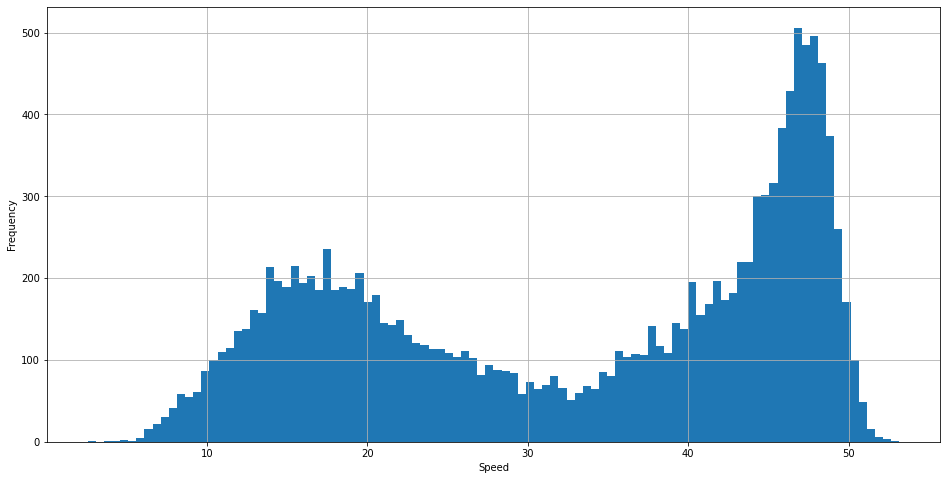

In [140]:
train.speed.hist(bins=100,figsize = (16,8))
plt.xlabel("Speed")
plt.ylabel("Frequency")

> ### 2.Trainning data preprocessing
**Problems:** 
* open train.csv, time is a type of string
* only one train.csv, no label
* Extract temporal features

| id       | date   |  speed  |
| --------   | -----:  | :----:  |
| 0      | 1/1/2017 0:00   |   43.002930     |
| 1        |  1/1/2017 1:00    |   46.1186969   |


In [141]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.info()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      14006 non-null  int64         
 1   date    14006 non-null  datetime64[ns]
 2   speed   14006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 328.4 KB


In [142]:
for df in (train,test):
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekday"] = df['date'].dt.weekday
    
for df in (train,test):
    df['hr_categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"   #工作日的早高峰7-9点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 18)&(df.hr >= 16), 'hr_categori'] = "rush"  #工作日的晚高峰16-18点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 7)|(df.hr > 18), 'hr_categori'] = "night"
    df.loc[(df.weekday >= 5)&(df.hr < 18)&(df.hr > 7), 'hr_categori'] = "day"                        #周末的白天
    df.loc[(df.weekday >= 5)&(df.hr <= 7)|(df.hr >= 18), 'hr_categori'] = "night"                    #周末的晚上

#######再加一个季节判断
season_dict = {
    1: 'spring', 2: 'spring', 3: 'spring',
    4: 'summer', 5: 'summer', 6: 'summer',
    7: 'fall', 8: 'fall', 9: 'fall',
    10: 'winter', 11: 'winter', 12: 'winter',}

for df in (train,test):
    df['season']=df['month'].map(season_dict)
    
####加载香港2017 2018节假日
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

    
train.head(100)

,id,date,speed,year,month,day,hr,weekday,hr_categori,season,only-ymd,y/n-holiday
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,0,6,night,spring,20170101,0
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,1,6,night,spring,20170101,0
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,2,6,night,spring,20170101,0
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,3,6,night,spring,20170101,0
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,4,6,night,spring,20170101,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2017-04-01 23:00:00,46.235164,2017,4,1,23,5,night,summer,20170401,0
96,96,2017-05-01 00:00:00,47.620550,2017,5,1,0,0,night,summer,20170501,1
97,97,2017-05-01 01:00:00,49.338859,2017,5,1,1,0,night,summer,20170501,1
98,98,2017-05-01 02:00:00,47.116882,2017,5,1,2,0,night,summer,20170501,1


In [143]:
train.corr()['speed']   #看看相关性

id            -0.002935
speed          1.000000
year           0.015102
month         -0.028827
day           -0.019485
hr            -0.390044
weekday        0.115887
y/n-holiday    0.055386
Name: speed, dtype: float64

In [144]:
df_train = train.drop(columns= ['only-ymd','date'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()

In [145]:
df_train.head()       #看最后的数据集

,id,speed,year,month,day,hr,weekday,hr_categori,season,y/n-holiday
0,0,43.002930,2017,1,1,0,6,night,spring,0
1,1,46.118696,2017,1,1,1,6,night,spring,0
2,2,44.294158,2017,1,1,2,6,night,spring,0
3,3,41.067468,2017,1,1,3,6,night,spring,0
4,4,46.448653,2017,1,1,4,6,night,spring,0


> ### 3.Feature transfermation
**Methods** 
* one-hot encoder

In [146]:
### df_train  df_test

year_train = pd.get_dummies(df_train['year'], prefix='y', prefix_sep='_')
year_test = pd.get_dummies(df_test['year'], prefix='y', prefix_sep='_')           #年份 分为 2017 2018 

month_train = pd.get_dummies(df_train['month'], prefix='m', prefix_sep='_') 
month_test = pd.get_dummies(df_test['month'], prefix='m', prefix_sep='_')

dom_train = pd.get_dummies(df_train['day'], prefix='dom', prefix_sep='_')       #day-dom
dom_test = pd.get_dummies(df_test['day'], prefix='dom', prefix_sep='_')

hour_train = pd.get_dummies(df_train['hr'], prefix='h', prefix_sep='_')         #h-hr
hour_test = pd.get_dummies(df_test['hr'], prefix='h', prefix_sep='_')

hour_cate_train = pd.get_dummies(df_train['hr_categori'], prefix='hc', prefix_sep='_')    #这个也是分类数据
hour_cate_test = pd.get_dummies(df_test['hr_categori'], prefix='hc', prefix_sep='_')

dow_train = pd.get_dummies(df_train['weekday'], prefix='dow', prefix_sep='_') #将确认为星期几也是属于分类的数据
dow_test = pd.get_dummies(df_test['weekday'], prefix='dow', prefix_sep='_')

ss_train = pd.get_dummies(df_train['season'], prefix='ss', prefix_sep='_') #将确认为星期几也是属于分类的数据
ss_test = pd.get_dummies(df_test['season'], prefix='ss', prefix_sep='_')

dom_train.head()

,dom_1,dom_2,dom_3,dom_4,dom_5,dom_6,dom_7,dom_8,dom_9,dom_10,...,dom_22,dom_23,dom_24,dom_25,dom_26,dom_27,dom_28,dom_29,dom_30,dom_31
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
#因为已经将属性标签（7个分类数据）进行独热编码处理了，那么原来的字段数据就可以进行删除了
#（这些数据有的会有大小之间的关系，造成不希望的结果），避免对模型预测产生影响
train = df_train.drop(['year','month','day','hr','weekday','hr_categori','season','id'],axis = 1)

test = df_test.drop(['year','month','day','hr','weekday','hr_categori','season'], axis = 1)

test['y_2017']=0

##加载编码过后的数据
Train_Master = pd.concat([train,
                          year_train,
                          ss_train,
                          dow_train,
                          hour_cate_train,
                          hour_train,
                          dom_train,
                          month_train ], axis=1)

Test_master = pd.concat([test, 
                         year_test,
                         ss_test,
                         dow_test,
                         hour_cate_test,
                         hour_test,
                         dom_test,
                         month_test ], axis=1)
test.head()

,y/n-holiday,y_2017
id,,
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


> ### 4.Modeling
**Methods** 
* lightGBM
* xgboost


In [228]:
from sklearn.model_selection import train_test_split
#留出法划分数据,就按照经典的37分
Train, Test = train_test_split(Train_Master, test_size = 0.2)  

#注意这里的test是从编码过后的训练集Train_Master中挑出来的；拥有训练数据中所有的特征，用来检测模型是否过拟合或者满足要求！

X_train = Train.drop(['speed'], axis=1)     #提取训练数据自变量

Y_train = Train["speed"]                    #提取训练数据因变量

X_test = Test.drop(['speed'], axis=1)       #提取测试数据自变量

Y_test = Test["speed"]                      #提取测试数据因变量

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)
#重新进行索引顺序


In [229]:
#加载模型，放入相关数据
dtrain = xgb.DMatrix(X_train, label=Y_train)    #放入训练数据
dvalid = xgb.DMatrix(X_test, label=Y_test)      #放入测试拟合与否的数据

dtest = xgb.DMatrix(Test_master)                #放入最终的需要提交的检测数据

In [230]:
X_test.head()

,y/n-holiday,y_2017,y_2018,ss_fall,ss_spring,ss_summer,ss_winter,dow_0,dow_1,dow_2,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
5831,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7695,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13910,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6991,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8604,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [231]:
# xgb_pars = {
#     'objective':          'reg:linear',
#     'learning_rate':      0.05,
#     'max_depth':          7,  
#     'subsample':          0.8,
#     'colsample_bytree':   0.7,
#     'colsample_bylevel':  0.7,
#     'silent':             1,
#     'reg_alpha':          1,
# }










# xgb_pars = {
#     'objective':          'reg:linear',
    
#     'learning_rate':      0.008,
    
#     'min_child_weight ':  1,
#     'max_depth':          10,  
#     'subsample':          0.7,
#     'colsample_bytree':   0.8,
#     'colsample_bylevel':  0.7,#
#     'gamma':              0.3,
    
#     'reg_alpha':          1,
    
#     'silent':             0,
    
# }

# xgb_pars = {
#     'objective':          'reg:linear',
#     'learning_rate':      0.05,
#     'max_depth':          7,  
#     'subsample':          0.8,
#     'colsample_bytree':   0.7,
#     'colsample_bylevel':  0.7,
#     'silent':             1,
#     'reg_alpha':          1,
# }


# xgb_pars = { 
#     'max_depth': 7,
#     'gamma' :0,
#     'eta':0.008, 
#     'subsample': 1,
#     'colsample_bytree': 0.9, 
#     'objective':'reg:linear',
#     'eval_metric':'rmse',
#     'silent': 0
# }

xgb_pars = {'min_child_weight': 1, 
            'eta': 0.03, 
            'colsample_bytree': 0.8, 
            'max_depth': 6,
            'subsample': 0.9, 
            'lambda': 1., 
            'nthread': -1, 
            
            'booster' : 'gbtree',
            'silent': 1,
            'eval_metric': 'rmse', 
            'objective': 'reg:linear'}

In [232]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#设置观测对象
model = xgb.train(xgb_pars, dtrain, 3000, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)


[14:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:33.99258	valid-rmse:34.18409
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:33.01387	valid-rmse:33.19682
[2]	train-rmse:32.06288	valid-rmse:32.23836
[3]	train-rmse:31.15836	valid-rmse:31.32815
[4]	train-rmse:30.26367	valid-rmse:30.42592
[5]	train-rmse:29.42053	valid-rmse:29.58156
[6]	train-rmse:28.60745	valid-rmse:28.76465
[7]	train-rmse:27.79311	valid-rmse:27.94344

[172]	train-rmse:5.14790	valid-rmse:5.57089
[173]	train-rmse:5.14306	valid-rmse:5.56622
[174]	train-rmse:5.14141	valid-rmse:5.56569
[175]	train-rmse:5.13872	valid-rmse:5.56388
[176]	train-rmse:5.13096	valid-rmse:5.55514
[177]	train-rmse:5.12488	valid-rmse:5.55068
[178]	train-rmse:5.11936	valid-rmse:5.54500
[179]	train-rmse:5.11268	valid-rmse:5.53723
[180]	train-rmse:5.10415	valid-rmse:5.52960
[181]	train-rmse:5.10256	valid-rmse:5.52916
[182]	train-rmse:5.09790	valid-rmse:5.52567
[183]	train-rmse:5.09290	valid-rmse:5.52245
[184]	train-rmse:5.08970	valid-rmse:5.52191
[185]	train-rmse:5.08286	valid-rmse:5.51740
[186]	train-rmse:5.08184	valid-rmse:5.51695
[187]	train-rmse:5.07538	valid-rmse:5.50979
[188]	train-rmse:5.07152	valid-rmse:5.50858
[189]	train-rmse:5.06985	valid-rmse:5.50734
[190]	train-rmse:5.06597	valid-rmse:5.50514
[191]	train-rmse:5.06445	valid-rmse:5.50514
[192]	train-rmse:5.05721	valid-rmse:5.49784
[193]	train-rmse:5.05220	valid-rmse:5.49454
[194]	train-rmse:5.05016	valid-r

[359]	train-rmse:4.48839	valid-rmse:5.15942
[360]	train-rmse:4.48583	valid-rmse:5.15798
[361]	train-rmse:4.48100	valid-rmse:5.15485
[362]	train-rmse:4.47881	valid-rmse:5.15492
[363]	train-rmse:4.47674	valid-rmse:5.15256
[364]	train-rmse:4.47547	valid-rmse:5.15255
[365]	train-rmse:4.47417	valid-rmse:5.15288
[366]	train-rmse:4.47264	valid-rmse:5.15300
[367]	train-rmse:4.46979	valid-rmse:5.15232
[368]	train-rmse:4.46804	valid-rmse:5.15125
[369]	train-rmse:4.46482	valid-rmse:5.15008
[370]	train-rmse:4.45970	valid-rmse:5.14595
[371]	train-rmse:4.45730	valid-rmse:5.14521
[372]	train-rmse:4.45553	valid-rmse:5.14437
[373]	train-rmse:4.45391	valid-rmse:5.14443
[374]	train-rmse:4.45252	valid-rmse:5.14480
[375]	train-rmse:4.45030	valid-rmse:5.14565
[376]	train-rmse:4.44728	valid-rmse:5.14400
[377]	train-rmse:4.44444	valid-rmse:5.14338
[378]	train-rmse:4.44306	valid-rmse:5.14344
[379]	train-rmse:4.43599	valid-rmse:5.14000
[380]	train-rmse:4.43332	valid-rmse:5.13913
[381]	train-rmse:4.43200	valid-r

[546]	train-rmse:4.01857	valid-rmse:4.93006
[547]	train-rmse:4.01683	valid-rmse:4.92948
[548]	train-rmse:4.01343	valid-rmse:4.92796
[549]	train-rmse:4.01244	valid-rmse:4.92825
[550]	train-rmse:4.01111	valid-rmse:4.92764
[551]	train-rmse:4.00842	valid-rmse:4.92574
[552]	train-rmse:4.00624	valid-rmse:4.92344
[553]	train-rmse:4.00380	valid-rmse:4.92211
[554]	train-rmse:4.00195	valid-rmse:4.92187
[555]	train-rmse:3.99940	valid-rmse:4.92009
[556]	train-rmse:3.99735	valid-rmse:4.91964
[557]	train-rmse:3.99539	valid-rmse:4.91846
[558]	train-rmse:3.99392	valid-rmse:4.91759
[559]	train-rmse:3.99258	valid-rmse:4.91774
[560]	train-rmse:3.98991	valid-rmse:4.91617
[561]	train-rmse:3.98794	valid-rmse:4.91547
[562]	train-rmse:3.98628	valid-rmse:4.91474
[563]	train-rmse:3.98394	valid-rmse:4.91328
[564]	train-rmse:3.98058	valid-rmse:4.91015
[565]	train-rmse:3.97858	valid-rmse:4.90878
[566]	train-rmse:3.97611	valid-rmse:4.90808
[567]	train-rmse:3.97432	valid-rmse:4.90706
[568]	train-rmse:3.97282	valid-r

[733]	train-rmse:3.66904	valid-rmse:4.77554
[734]	train-rmse:3.66752	valid-rmse:4.77539
[735]	train-rmse:3.66615	valid-rmse:4.77507
[736]	train-rmse:3.66409	valid-rmse:4.77432
[737]	train-rmse:3.66193	valid-rmse:4.77348
[738]	train-rmse:3.66066	valid-rmse:4.77345
[739]	train-rmse:3.65976	valid-rmse:4.77367
[740]	train-rmse:3.65832	valid-rmse:4.77324
[741]	train-rmse:3.65690	valid-rmse:4.77269
[742]	train-rmse:3.65594	valid-rmse:4.77297
[743]	train-rmse:3.65464	valid-rmse:4.77241
[744]	train-rmse:3.65356	valid-rmse:4.77230
[745]	train-rmse:3.65180	valid-rmse:4.77128
[746]	train-rmse:3.65033	valid-rmse:4.77022
[747]	train-rmse:3.64957	valid-rmse:4.77016
[748]	train-rmse:3.64817	valid-rmse:4.76918
[749]	train-rmse:3.64648	valid-rmse:4.76802
[750]	train-rmse:3.64482	valid-rmse:4.76724
[751]	train-rmse:3.64379	valid-rmse:4.76741
[752]	train-rmse:3.64146	valid-rmse:4.76677
[753]	train-rmse:3.64017	valid-rmse:4.76696
[754]	train-rmse:3.63870	valid-rmse:4.76693
[755]	train-rmse:3.63771	valid-r

[920]	train-rmse:3.42031	valid-rmse:4.69792
[921]	train-rmse:3.41921	valid-rmse:4.69814
[922]	train-rmse:3.41833	valid-rmse:4.69829
[923]	train-rmse:3.41741	valid-rmse:4.69785
[924]	train-rmse:3.41648	valid-rmse:4.69739
[925]	train-rmse:3.41566	valid-rmse:4.69692
[926]	train-rmse:3.41482	valid-rmse:4.69673
[927]	train-rmse:3.41327	valid-rmse:4.69587
[928]	train-rmse:3.41209	valid-rmse:4.69509
[929]	train-rmse:3.41124	valid-rmse:4.69519
[930]	train-rmse:3.40996	valid-rmse:4.69516
[931]	train-rmse:3.40921	valid-rmse:4.69461
[932]	train-rmse:3.40817	valid-rmse:4.69438
[933]	train-rmse:3.40732	valid-rmse:4.69420
[934]	train-rmse:3.40572	valid-rmse:4.69364
[935]	train-rmse:3.40455	valid-rmse:4.69331
[936]	train-rmse:3.40337	valid-rmse:4.69257
[937]	train-rmse:3.40230	valid-rmse:4.69295
[938]	train-rmse:3.40076	valid-rmse:4.69231
[939]	train-rmse:3.39990	valid-rmse:4.69255
[940]	train-rmse:3.39841	valid-rmse:4.69191
[941]	train-rmse:3.39733	valid-rmse:4.69250
[942]	train-rmse:3.39647	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

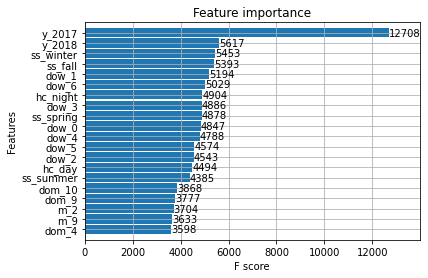

In [221]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前30特征值绘制条状图


In [181]:
pred = model.predict(dtest)


submission = pd.concat([test.drop(['y_2017','y/n-holiday'],axis = 1), pd.DataFrame(pred)], axis=1)

     #这里的test.drop(['y_2017','y/n-holiday'],axis = 1)就是只有id的表

submission.columns = ['id','speed']   #按照要求提交保留的数据

submission.to_csv("submission.csv", index=False)


In [182]:
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission2.csv", index=False)